# GT4Py Tutorial

### Introduction

This notebook will show how to create a simple GT4Py stencil that copies data from one varaible to another.

### Notebook Requirements

- Python v3.11.x to v3.12.x
- [NOAA/NASA Domain Specific Language Middleware](https://github.com/NOAA-GFDL/NDSL)
- `ipykernel==6.1.0`
- [`ipython_genutils`](https://pypi.org/project/ipython_genutils/)

## Quick GT4Py (Cartesian version) Overview

GT4Py enables a developer to write code using a stencil-based language implemented using Python syntax.  Performance is achieved when the GT4Py Python code is translated and compiled into a lower level language such as C++ and CUDA, enabling the codebase to execute on a multitude of architectures.  In this notebook, we will cover the basics of GT4Py and teach the developer the intracies of the DSL. Additional information about GT4Py can be found at the [GT4Py site](https://gridtools.github.io/gt4py/latest/index.html).

### GT4Py Parallel/Execution Model

Within a 3-dimensional domain, GT4Py considers computations in two parts.  Using an `(I,J,K)` coordinate system as a reference, GT4Py separates computations in the Horizontal (IJ) spatial plane and Vertical (K) spatial interval.  In the Horizontal spatial plane, computations are executed in parallel.  This also means that within the Horizontal spatial plane, there is no assumed order to the calculations within the plane.  In the Vertical spatial interval, comptuations are specified by an iteration policy that will be discussed through examples. This also means that the iteration policy used in the vertical spatial interval dictates the "order" of the Horizontal plane calculations.

### Copy Stencil example

To quickly demonstrate how to implement a GT4Py stencil, we'll step through an stencil example that copies the values of one array into another array.  First, we import several modules. 

In [25]:
from gt4py.cartesian.gtscript import PARALLEL, computation, interval, stencil
from ndsl.dsl.typing import FloatField
import gt4py.storage as gt_storage
import numpy as np
from boilerplate import plot_field_at_k0

As we walk through the example, we'll highlight different terms and such from the imports.  Let's first define, in GT4Py terms, two arrays of size 5 by 5 by 1 (dimensionally `I` by `J` by `K`).  These arrays are defined using the `gt_storage` object.  The `gt_storage` array will be created using two different functions: `.zero` and `.from_array`.  The functionality of these functions are essentially self-explanatory, but we'll mention that the `.from_array` function lets the user define a `numpy` array whose data can be passed into a `gt_storage`.

These `gt_storage` functions take several parameters.  

- `backend` tells GT4Py how to optimally lay out the array for a particular architecture.  In this example, we will use the `numpy` backend since it's the easiest for debugging and testing purposes.  

- `data` is the numpy array data that gets passed into a `gt_storage`

- `dtype` is the data type

- `shape` is the array shape passed in as a tuple.

In [26]:
backend = 'numpy'

nx = 5
ny = 5
nz = 5

size = nx * ny * nz
shape = (nx, ny, nz)

qty_out = gt_storage.zeros(
    backend=backend,
    dtype=float,
    shape=shape,
)

arr = np.indices(shape).sum(axis=0)  # Value of each entry is sum of the I and J index at each point
qty_in = gt_storage.from_array(
    data=arr,
    backend=backend,
    dtype=float,
)

We will next create a simple stencil that copies values from one `gt_storage` to another.  A stencil will look like a Python subroutine or function except that it uses specific GT4Py functionalities.  This stencil can be implemented as follows using GT4Py.

In [27]:
@stencil(backend=backend)
def copy_stencil(input_field: FloatField,
                 output_field: FloatField):
    with computation(PARALLEL), interval(...):
        output_field = input_field

We see that this particular stencil does not contain any iterative loops.  As mentioned above in the notebook, GT4Py has a particular computation policy that essentially executes in parallel within an `IJ` plane and is user defined in the `K` interval.  This execution policy in the `K` interval is dictated by the `computation` and `interval` keywords, and in this example, the line `with computation(PARALLEL), interval(...)` defines the `K` interval execution.  

- `with computation(PARALLEL)` means that there's no order preference to execution in `K`, which means that the `K` interval can be computed in parallel to potentially gain performace if computational resources are available.

- `interval(...)` means that the entire `K` interval is executed.  Instead of `(...)`, more specific intervals can be specified using a tuple of integers.  For example, `interval(0,2)` indicates that interval `K` = 0 to 1 is executed.

The decorator `@stencil(backend=backend)` converts `copy_stencil` to use the specified `backend` to create the "executable" code.

Note that the input and output parameters to `copy_stencil` are type `FloatField`, which is essentially a 3-dimensional `gt_storage` array of `float` types.

Plotting values of qty_in
Min and max values: 12.0 0.0


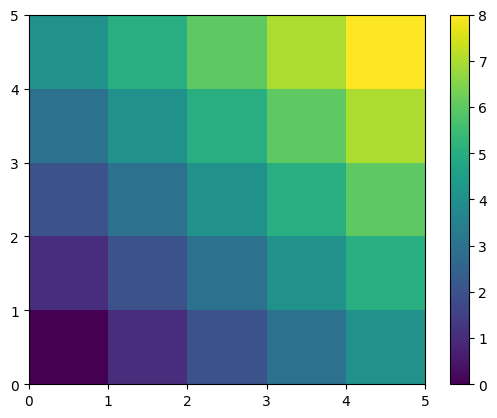

Plotting values of qty_out
Min and max values: 0.0 0.0


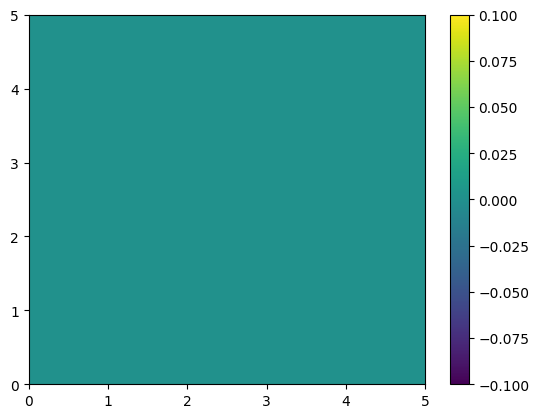

Executing `copy_stencil`
Plotting qty_out from `copy_stencil`
Min and max values: 12.0 0.0


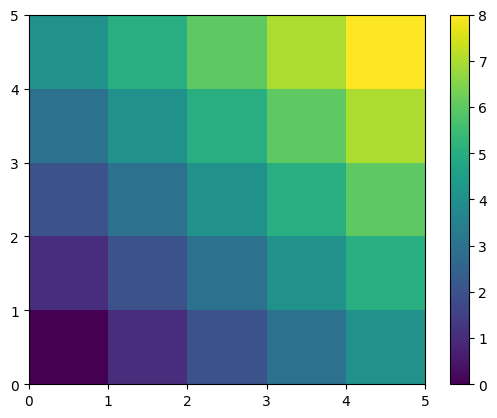

In [28]:
print("Plotting values of qty_in")
plot_field_at_k0(qty_in)
print("Plotting values of qty_out")
plot_field_at_k0(qty_out)
print("Executing `copy_stencil`")
copy_stencil(qty_in, qty_out)
print("Plotting qty_out from `copy_stencil`")
plot_field_at_k0(qty_out)